# Using a CFSv2 forecast

__[CFSv2](https://data.planetos.com/datasets/ncep_cfsv2)__  is a seasonal forecast system, used for analysing past climate and also making seasonal, up to 9-month, forecasts. Here we give a brief example on how to use Planet OS API to merge 9-month forecasts started at different initial times, into a single ensemble forecast.

Ensemble forecasting is a traditional technique in medium range (up to 10 days) weather forecasts, seasonal forecasts and climate modelling. By changing initial conditions or model parameters, a range of forecasts is created, which differ from each other slightly, due to the chaotic nature of fluid dynamics (which weather modelling is a subset of). For weather forecasting, the ensemble is usually created by small changes in initial conditions, but for seasonal forecast, it is much easier to just take real initial conditions every 6-hours. Here we are going to show, first how to merge the different dates into a single plot with the help of python pandas library, and in addition we show that even 6-hour changes in initial conditions can lead to large variability in long range forecasts. 

If you have more interest in Planet OS API, please refer to our official __[documentation](data.planetos.com/datasets)__.

Please also note that the `API_client` python routine, used in this notebook, is still experimental and will change in the future, so take it just as a guidance using the API, and not as an official tool.

In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from API_client.python import datahub
from API_client.python.lib import dataset
from API_client.python.lib import variables

The API needs a file `APIKEY` with your API key in the work folder. We initialize a datahub and dataset objects.

In [3]:
dh = datahub.datahub(server='api.planetos.com',version='v1')
ds = dataset.dataset('ncep_cfsv2', dh, debug=False)

In [4]:
ds.vars=variables.variables(ds.variables(), {'reftimes':ds.reftimes,'timesteps':ds.timesteps},ds)

In order to the automatic location selection to work, add your custom location to the `API_client.python.lib.predef_locations` file.

In [33]:
for locat in ['Võru']:
    ds.vars.Convective_Precipitation_Rate_surface.get_values(count=1000, location=locat, reftime='2018-04-20T18:00:00',
                                                            reftime_end='2018-05-02T18:00:00')
    ds.vars.Maximum_temperature_height_above_ground.get_values(count=1000, location=locat, reftime='2018-04-20T18:00:00',
                                                            reftime_end='2018-05-02T18:00:00')

In [21]:
## uncomment following line to see full pandas table
## ds.vars.Convective_Precipitation_Rate_surface.values['Võru']

Here we clean the table just a bit and create time based index.

In [22]:
ddd = ds.vars.Convective_Precipitation_Rate_surface.values['Võru'][['reftime','time','Convective_Precipitation_Rate_surface']]
dd_test=ddd.set_index('time')

Next, we resample the data to 1-month totals.

In [26]:
reft_unique = ds.vars.Convective_Precipitation_Rate_surface.values['Võru']['reftime'].unique()
nf = []
for reft in reft_unique:
    abc = dd_test[dd_test.reftime==reft].resample('M').sum()
    abc['Convective_Precipitation_Rate_surface'+'_'+reft.astype(str)] = \
         abc['Convective_Precipitation_Rate_surface']*6*3600
    del abc['Convective_Precipitation_Rate_surface']
    nf.append(abc)
nf2=pd.concat(nf,axis=1)

In [28]:
# uncomment to see full pandas table
# nf2

Finally, we are visualizing the monthly precipitation for each different forecast, in a single plot. 

<IPython.core.display.Javascript object>


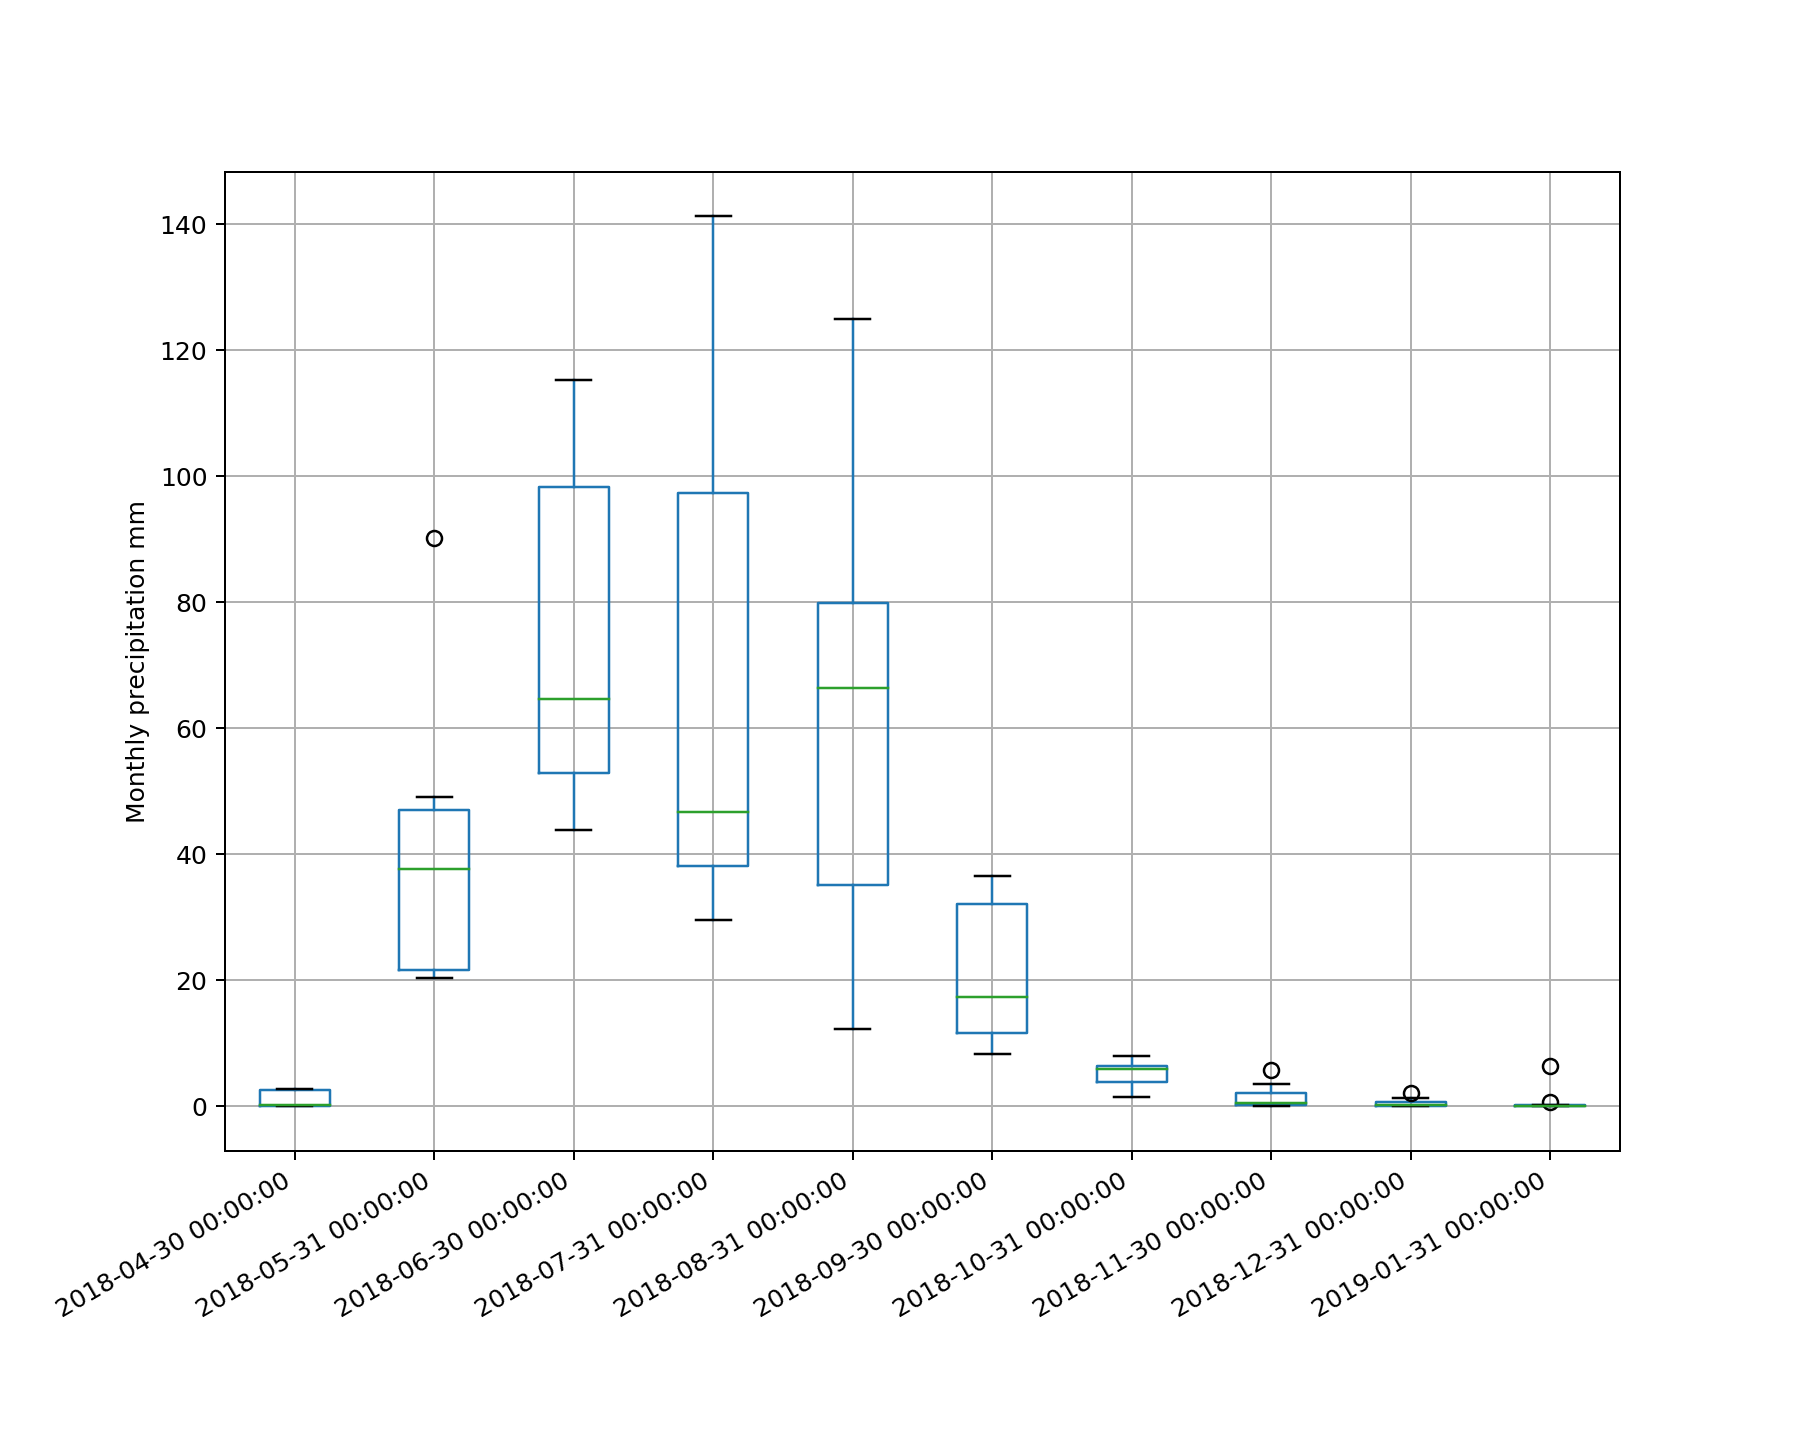

In [34]:
fig=plt.figure(figsize=(10,8))
nf2.transpose().boxplot()
plt.ylabel('Monthly precipitation mm')
fig.autofmt_xdate()
plt.show()